
# Aufgabe 2: CNN‑Experimente auf eigenem Bilddatensatz (PyTorch)

*Vorbereitet: 2025-11-11 22:55 UTC*

Ziel: **Accuracy verbessern** und **Overfitting reduzieren**, indem Sie gezielt Hyperparameter und Transforms variieren.  
Abgabe: Notebook + kurzer Bericht (1–2 Seiten) + bestes Modell + 1 Beispiel‑Inference.



## Aufgabenstellung (kurz)
1. **Eigenen Datensatz** nutzen (oder den aus der Voraufgabe). Struktur (für `ImageFolder`):
   ```
   data/mydata/
     train/
       class_a/ *.jpg
       class_b/ *.jpg
     val/
       class_a/ *.jpg
       class_b/ *.jpg
   ```
   Bilder nicht zu groß (z. B. 64–128 px).
2. **Variieren Sie** (mind. 6 Experimente, pro Run nur 1–2 Änderungen):
   - Anzahl **Conv2d**‑Layer
   - **Output‑Channels** pro Layer
   - **Kernelgröße**
   - **Stride** (1 oder 2), **padding** (z. B. `"same"`)
   - **Dropout‑Rate**
   - **Transforms** (mindestens `ToTensor()`)
   - Optional: Optimizer/Scheduler, Batch Size
3. **Bestes Modell speichern** und **eine Inference** mit einem Bild zeigen.
4. **Dokumentation**: Tabelle mit Runs (Hyperparameter → Val‑Accuracy/GAP) + kurze Begründungen.

**Bewertung:** 40% Experimente · 30% Auswertung · 20% Codequalität · 10% Inference/Save.


## Setup & Importe

## 🐝 Beispiel-Datensatz: Hymenoptera (Bees vs Ants)

Dieser kleine Datensatz stammt von **Microsoft Research Cambridge**  
und enthält Bilder von **Bienen** und **Ameisen** – perfekt für erste CNN-Experimente.

- 244 Trainingsbilder, 153 Validierungsbilder  
- Zwei Klassen: `ants`, `bees`  
- Ideale Größe für schnelle Trainingsläufe (unter 1 Minute pro Epoche auf CPU)

### Download (automatisch)
PyTorch kann den Datensatz direkt herunterladen und entpacken:

```python
import torchvision
from torchvision import datasets, transforms

data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
torchvision.datasets.utils.download_and_extract_archive(data_url, "./data")

# Danach liegt der Datensatz unter:
# ./data/hymenoptera_data/train
# ./data/hymenoptera_data/val


In [11]:
import torchvision
from torchvision import datasets, transforms

data_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
torchvision.datasets.utils.download_and_extract_archive(data_url, "./data")

# Danach liegt der Datensatz unter:
# ./data/hymenoptera_data/train
# ./data/hymenoptera_data/val
import os, math, random, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision import datasets
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


100%|██████████| 47.3M/47.3M [00:01<00:00, 26.1MB/s]


device(type='cpu')

## Konfiguration

In [12]:

DATA_DIR = Path("./data/hymenoptera_data")  # <-- ggf. anpassen
IMG_SIZE = 96
BATCH_TRAIN = 64
BATCH_VAL = 128
NUM_WORKERS = 0 if os.name == "nt" else 2
PIN_MEMORY = torch.cuda.is_available()
EPOCHS = 12
LR = 3e-4
WEIGHT_DECAY = 5e-4

print(f"Device: {DEVICE} | Data: {DATA_DIR} | IMG_SIZE={IMG_SIZE}")


Device: cpu | Data: data/hymenoptera_data | IMG_SIZE=96


## Transforms (leicht & stark)

In [13]:

train_tfms_light = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

train_tfms_strong = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
])

val_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
])

train_tfms = train_tfms_light  # wählen


## Daten laden (`ImageFolder`)

In [14]:

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Datensatzordner nicht gefunden: {DATA_DIR}. "
                            "Bitte Struktur gemäß Aufgabenstellung anlegen.")

train_ds = datasets.ImageFolder(DATA_DIR / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(DATA_DIR / "val",   transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0))
val_dl   = DataLoader(val_ds,   batch_size=BATCH_VAL, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY,
                      persistent_workers=(NUM_WORKERS>0))

CLASSES = train_ds.classes
print("Klassen:", CLASSES)
print("Train/Val Größen:", len(train_ds), len(val_ds))

xb, yb = next(iter(train_dl))
print("Batch:", xb.shape, yb.shape)


Klassen: ['ants', 'bees']
Train/Val Größen: 244 153
Batch: torch.Size([64, 3, 96, 96]) torch.Size([64])


## Schnellansicht eines Batches

['ants', 'ants', 'ants', 'ants', 'bees', 'bees', 'bees', 'ants', 'ants', 'ants', 'ants', 'bees', 'ants', 'ants', 'bees', 'bees']


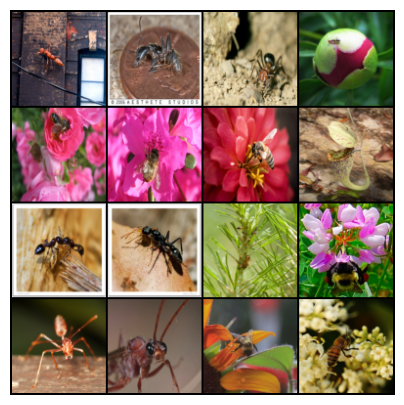

In [15]:

def show_batch(x, y, classes, n=16):
    grid = make_grid(x[:n], nrow=int(math.sqrt(n)), normalize=True)
    plt.figure(figsize=(5,5)); plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    print([classes[i] for i in y[:n].tolist()])
    plt.show()

show_batch(xb, yb, CLASSES, n=16)


## Modell‑Skeleton (anpassbar)

In [16]:

class SmallCNN(nn.Module):
    def __init__(self, n_classes, p_drop_feat=0.25, p_drop_head=0.5,
                 channels=(32, 64, 128), kernel_size=3, use_same_padding=True):
        super().__init__()
        pad = "same" if use_same_padding else 0
        c1, c2, c3 = channels

        self.features = nn.Sequential(
            nn.Conv2d(3, c1, kernel_size, padding=pad), nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, kernel_size, padding=pad), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(c1, c2, kernel_size, padding=pad), nn.ReLU(inplace=True),
            nn.Conv2d(c2, c2, kernel_size, padding=pad), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Dropout(p_drop_feat),
            nn.Conv2d(c2, c3, kernel_size, padding=pad), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((4,4)),
            nn.Flatten(),
            nn.Linear(c3*4*4, 256), nn.ReLU(inplace=True),
            nn.Dropout(p_drop_head),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

model = SmallCNN(n_classes=len(CLASSES)).to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6


0.664482

## Training & Evaluation Utilities

In [17]:

def accuracy(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    n, total_loss, total_acc = 0, 0.0, 0.0
    for x,y in loader:
        x,y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        b = y.size(0)
        total_loss += loss.item() * b
        total_acc  += (logits.argmax(1) == y).sum().item()
        n += b
    return total_loss/n, total_acc/n

def train(model, train_dl, val_dl, epochs=12, lr=3e-4, wd=5e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    loss_fn = nn.CrossEntropyLoss()

    best_acc, best_path = 0.0, "best_cnn.pt"
    history = []

    for ep in range(1, epochs+1):
        model.train()
        pbar = tqdm(train_dl, desc=f"Epoch {ep}/{epochs}")
        total, correct, train_loss = 0, 0, 0.0

        for x,y in pbar:
            x,y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

            train_loss += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
            pbar.set_postfix(loss=f"{loss.item():.3f}")

        sched.step()
        tr_loss = train_loss/total
        tr_acc = correct/total

        val_loss, val_acc = evaluate(model, val_dl, loss_fn)
        history.append((ep, tr_loss, tr_acc, val_loss, val_acc))

        print(f"[val] loss={val_loss:.4f} acc={val_acc:.4f}")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({"model": model.state_dict(),
                        "classes": CLASSES,
                        "acc": best_acc}, best_path)
            print(f"  ↳ saved new best to {best_path} (acc={best_acc:.4f})")

    return history, best_acc

history, best_acc = train(model, train_dl, val_dl)
best_acc


Epoch 1/12: 100%|██████████| 4/4 [00:01<00:00,  3.47it/s, loss=0.694]


[val] loss=0.6923 acc=0.5425
  ↳ saved new best to best_cnn.pt (acc=0.5425)


Epoch 2/12: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s, loss=0.692]


[val] loss=0.6933 acc=0.4575


Epoch 3/12: 100%|██████████| 4/4 [00:01<00:00,  3.74it/s, loss=0.691]


[val] loss=0.6912 acc=0.5490
  ↳ saved new best to best_cnn.pt (acc=0.5490)


Epoch 4/12: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s, loss=0.689]


[val] loss=0.6849 acc=0.5752
  ↳ saved new best to best_cnn.pt (acc=0.5752)


Epoch 5/12: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s, loss=0.684]


[val] loss=0.6788 acc=0.5752


Epoch 6/12: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s, loss=0.649]


[val] loss=0.6777 acc=0.6144
  ↳ saved new best to best_cnn.pt (acc=0.6144)


Epoch 7/12: 100%|██████████| 4/4 [00:01<00:00,  3.80it/s, loss=0.671]


[val] loss=0.6767 acc=0.6078


Epoch 8/12: 100%|██████████| 4/4 [00:01<00:00,  3.72it/s, loss=0.656]


[val] loss=0.6773 acc=0.5817


Epoch 9/12: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s, loss=0.696]


[val] loss=0.6777 acc=0.5752


Epoch 10/12: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s, loss=0.624]


[val] loss=0.6779 acc=0.5686


Epoch 11/12: 100%|██████████| 4/4 [00:01<00:00,  3.77it/s, loss=0.655]


[val] loss=0.6780 acc=0.5686


Epoch 12/12: 100%|██████████| 4/4 [00:01<00:00,  3.73it/s, loss=0.653]


[val] loss=0.6780 acc=0.5621


0.6143790849673203

## Lernkurven (Loss/Accuracy)

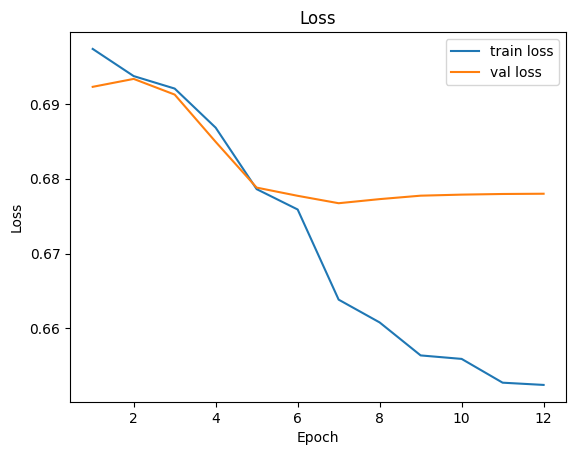

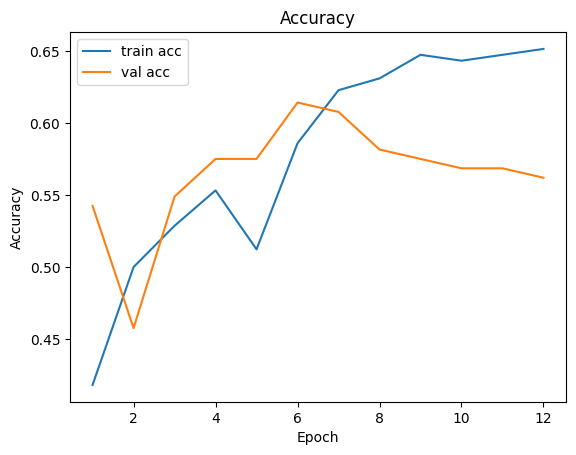

In [18]:

ep, trl, tra, val, va = zip(*history)

plt.figure()
plt.plot(ep, trl, label="train loss")
plt.plot(ep, val, label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

plt.figure()
plt.plot(ep, tra, label="train acc")
plt.plot(ep, va, label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy"); plt.show()


## Fehlklassifikationen (Beispiele)

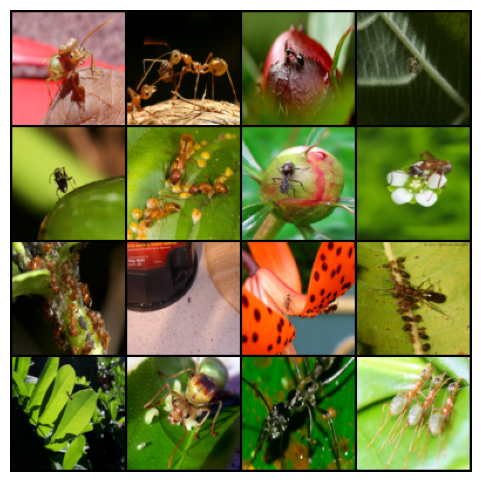

True  : ['ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants', 'ants']
Pred  : ['bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees', 'bees']


In [19]:

@torch.no_grad()
def misclassified_examples(model, loader, classes, n=16):
    model.eval()
    xs, ys, ps = [], [], []
    for x,y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        pred = logits.argmax(1).cpu()
        mism = pred.ne(y)
        idx = torch.where(mism)[0]
        for i in idx.tolist():
            xs.append(x[i].cpu())
            ys.append(y[i].item())
            ps.append(pred[i].item())
            if len(xs) >= n:
                break
        if len(xs) >= n:
            break
    if not xs:
        print("Keine Fehlklassifikationen im ersten Batch gefunden.")
        return
    grid = make_grid(torch.stack(xs), nrow=int(math.sqrt(len(xs))), normalize=True)
    plt.figure(figsize=(6,6)); plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.show()
    print("True  :", [classes[t] for t in ys])
    print("Pred  :", [classes[p] for p in ps])

misclassified_examples(model, val_dl, CLASSES, n=16)


## Bestes Modell laden & Inference

In [20]:

ckpt = torch.load("best_cnn.pt", map_location=DEVICE)
model.load_state_dict(ckpt["model"])
classes = ckpt.get("classes", CLASSES)

from PIL import Image
@torch.no_grad()
def predict_image(path, model, transform, classes):
    model.eval()
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(DEVICE)
    logits = model(x)
    probs = logits.softmax(dim=1).squeeze(0)
    topk = probs.topk(min(3, len(classes)))
    return [(classes[i], float(probs[i])) for i in topk.indices]

example_path = None
for cls in classes:
    cls_dir = Path("./data/mydata/val")/cls
    if cls_dir.exists():
        images = list(cls_dir.glob("*.jpg")) + list(cls_dir.glob("*.png")) + list(cls_dir.glob("*.jpeg"))
        if images:
            example_path = images[0]
            break

if example_path is not None:
    print("Beispielbild:", example_path)
    print(predict_image(example_path, model, val_tfms, classes))
else:
    print("Kein Beispielbild im Val-Ordner gefunden.")


Kein Beispielbild im Val-Ordner gefunden.


## Ergebnistabelle (ausfüllen)


| Run | Layers | Channels        | Kernel | Stride | Padding | Dropout | Transforms | Optim | BS | Epochs | Val Acc | Train–Val Gap |
|-----|--------|------------------|--------|--------|---------|---------|------------|-------|----|--------|---------|---------------|
| 1   | 2      | 32/64            | 3      | 1      | same    | 0.25    | light      | AdamW | 64 | 12     |         |               |
| 2   | 3      | 32/64/128        | 3      | 1      | same    | 0.25    | strong     | AdamW | 64 | 12     |         |               |
| …   | …      | …                | …      | …      | …       | …       | …          | …     | …  | …      |         |               |


## Hinweise / Tipps


- Beginnen Sie **einfach** (2×Conv → Pool), dann schrittweise tiefer/breiter.
- **Overfitting**: Dropout erhöhen, stärkere Augmentierung, Weight Decay, Early Stopping.
- **Downsampling** nicht zu früh/zu stark; oft besser: `stride=1` + `MaxPool` nach 1–2 Convs.
- **Padding="same"** hält die Spatial‑Größen stabil und vereinfacht Shape‑Berechnungen.
- Kleine Datensätze: **Transfer Learning** als Vergleich (z. B. `resnet18` einfrieren, Kopf neu).
- Setzen Sie **Seed** (gegeben) für Reproduzierbarkeit. Achten Sie auf saubere, modulare Funktionen.
